#  Решение задачи классификации при помощи пакета `torch`.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://lightning.ai/docs/torchmetrics/stable/
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://www.learnpytorch.io/02_pytorch_classification/
* https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler
* https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb45
* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
* https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b7
* https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
* https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss52

## Задачи для совместного разбора

In [124]:
# from torchtyping import TensorType, patch_typeguard
# from typeguard import typechecked
import torch as th

# Scalar = TensorType[()]
# patch_typeguard()

1\. Обсудите подходы к решению задачи классификации на примере синтетического датасета.

In [125]:
num_samples = 1000
num_features = 10
num_classes = 3

X = th.randn(num_samples, num_features)
y = th.randint(0, num_classes, (num_samples, ))

In [126]:
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self, n_inputs: int, n_classes: int) -> None:
    super().__init__()
    self.fc1 = nn.Linear(n_inputs, n_classes)

  def forward(self, X: th.Tensor) -> th.Tensor:
    return self.fc1(X)

In [127]:
model = Classifier(num_features, num_classes)
preds = model(X)
preds.shape

torch.Size([1000, 3])

In [128]:
preds[:5]

tensor([[-0.2249, -1.0746, -0.0884],
        [ 0.3898, -0.1105, -0.0264],
        [-0.0850, -0.5960,  0.4402],
        [-0.0529, -0.6524,  0.1380],
        [ 0.0927, -0.2647, -0.4871]], grad_fn=<SliceBackward0>)

In [129]:
preds.argmax(dim=1)[:5]

tensor([2, 0, 2, 2, 0])

In [130]:
y[:5]

tensor([1, 2, 1, 0, 2])

In [131]:
criterion = nn.CrossEntropyLoss()
loss = criterion(preds, y)

In [132]:
num_samples = 1000
num_features = 10
num_classes = 2

X = th.randn(num_samples, num_features)
y = th.randint(0, num_classes, (num_samples, ))

In [133]:
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self, n_inputs: int, n_classes: int) -> None:
    super().__init__()
    self.fc1 = nn.Linear(n_inputs, n_classes)

  def forward(self, X: th.Tensor) -> th.Tensor:
    return self.fc1(X)

In [134]:
model = Classifier(num_features, 1)
preds = model(X)

In [135]:
preds.shape

torch.Size([1000, 1])

In [136]:
preds.sigmoid()[:5]

tensor([[0.4323],
        [0.4070],
        [0.3875],
        [0.3686],
        [0.4152]], grad_fn=<SliceBackward0>)

In [137]:
(preds.sigmoid() >= 0.5)[:5]

tensor([[False],
        [False],
        [False],
        [False],
        [False]])

In [138]:
y[:5]

tensor([1, 0, 1, 0, 1])

In [139]:
criterion = nn.BCEWithLogitsLoss()

criterion(preds.flatten(), y.float())

tensor(0.7497, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу классификации. Разделите датасет на обучающую и тестовую выборку в соотношении 80% на 20%. В качестве функции потерь используйте реализацию `CrossEntropyLoss` из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`.

Используйте модель, состоящую из двух слоев:
1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 2 нейронами.

Выведите график изменения значения функции потерь в процессе обучения. Выведите на экран значения Accuracy, Precision, Recall и F1 для обучающего и тестового множества.

Выведите на экран облако точек с цветом, соответствующим предсказаниям модели на всем датасете (и обучающей, и тестовой части).

- [X] Проверено на семинаре


In [140]:
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics as M

In [141]:
def train_model(model, criterion, optimizer, loader, n_epochs=1000, print_every=500):
    epoch_losses = []
    for epoch in range(n_epochs + 1):
        model.train()
        accum_losses = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            accum_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = np.mean(accum_losses)
        epoch_losses.append(epoch_loss)
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}')
    return epoch_losses

In [142]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_loss_curve(epoch_losses, window_size=50):
    smoothed_losses = moving_average(epoch_losses, window_size)
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_losses, label=f'Скользящее среднее (размер окна {window_size})', linewidth=2)
    plt.title('График изменения значения функции потерь (сглаженный)')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение функции потерь')
    plt.grid(True)
    plt.legend()
    plt.show()

In [143]:
from sklearn.datasets import make_circles
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

In [144]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=2),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [145]:
dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [146]:
epoch_losses = train_model(model, criterion, optimizer, train_loader)

Epoch [0/1000], Loss: 0.7709


Epoch [500/1000], Loss: 0.6939
Epoch [1000/1000], Loss: 0.6959


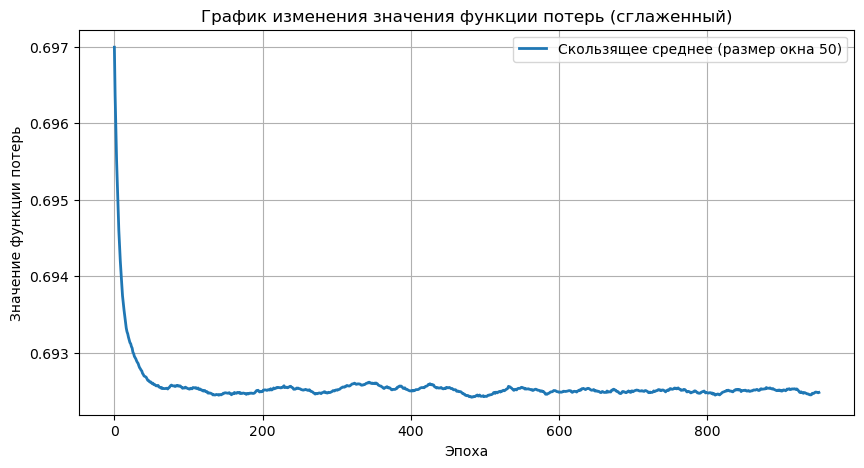

In [147]:
plot_loss_curve(epoch_losses)

In [148]:
y_pred_train = model(train_dataset[:][0]).argmax(dim=1)
y_true_train = train_dataset[:][1]
print(f"Train Accuracy: {M.Accuracy(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Recall: {M.Precision(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train F1Score: {M.Recall(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Precision: {M.F1Score(task='binary')(y_pred_train, y_true_train).item():.4f}")

Train Accuracy: 0.5263
Train Recall: 0.5272
Train F1Score: 0.5547
Train Precision: 0.5406


In [149]:
y_pred_test = model(test_dataset[:][0]).argmax(dim=1)
y_true_test = test_dataset[:][1]
print(f"Test Accuracy: {M.Accuracy(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Recall: {M.Precision(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test F1Score: {M.Recall(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Precision: {M.F1Score(task='binary')(y_pred_test, y_true_test).item():.4f}")

Test Accuracy: 0.4350
Test Recall: 0.4336
Test F1Score: 0.5000
Test Precision: 0.4645


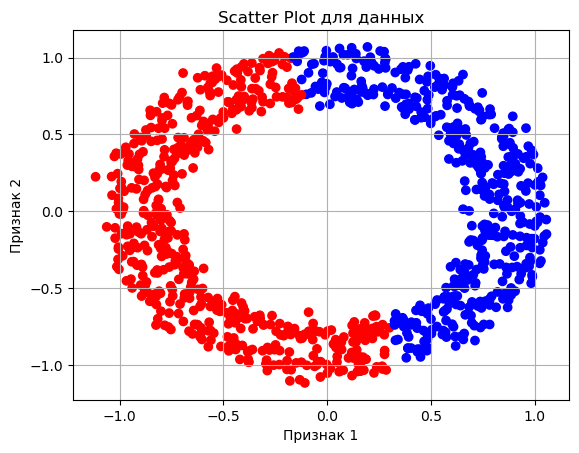

In [150]:
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=model(dataset[:][0]).argmax(dim=1), cmap='bwr')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Scatter Plot для данных')
plt.grid(True)
plt.show()

<p class="task" id="2"></p>

2\. Повторите задачу 1, используя другую архитектуру нейронной сети.

1. Полносвязный слой с 10 нейронами;
2. Функция активации ReLU;
3. Полносвязный слой с 2 нейронами.

- [X] Проверено на семинаре

In [151]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=2),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [152]:
dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
epoch_losses = train_model(model, criterion, optimizer, train_loader)

Epoch [0/1000], Loss: 0.7883
Epoch [500/1000], Loss: 0.6616
Epoch [1000/1000], Loss: 0.5913


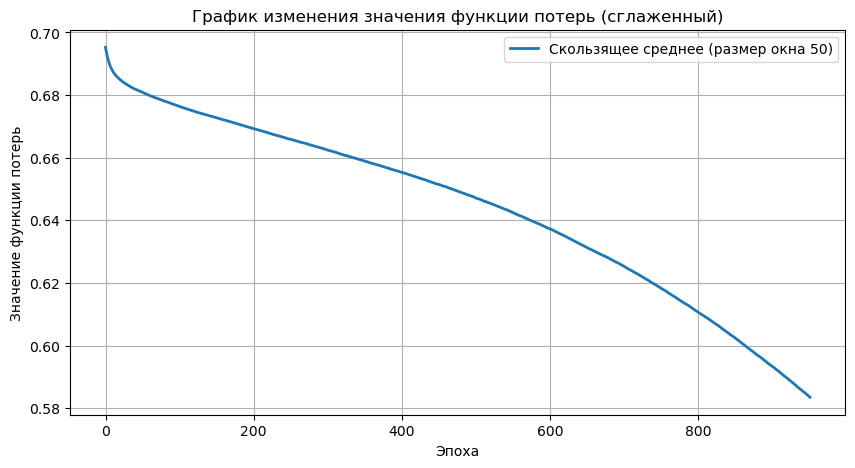

In [153]:
plot_loss_curve(epoch_losses)

In [154]:
y_pred_train = model(train_dataset[:][0]).argmax(dim=1)
y_true_train = train_dataset[:][1]
print(f"Train Accuracy: {M.Accuracy(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Recall: {M.Precision(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train F1Score: {M.Recall(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Precision: {M.F1Score(task='binary')(y_pred_train, y_true_train).item():.4f}")

Train Accuracy: 0.8537
Train Recall: 0.8421
Train F1Score: 0.8734
Train Precision: 0.8575


In [155]:
y_pred_test = model(test_dataset[:][0]).argmax(dim=1)
y_true_test = test_dataset[:][1]
print(f"Test Accuracy: {M.Accuracy(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Recall: {M.Precision(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test F1Score: {M.Recall(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Precision: {M.F1Score(task='binary')(y_pred_test, y_true_test).item():.4f}")

Test Accuracy: 0.8050
Test Recall: 0.8021
Test F1Score: 0.7938
Test Precision: 0.7979


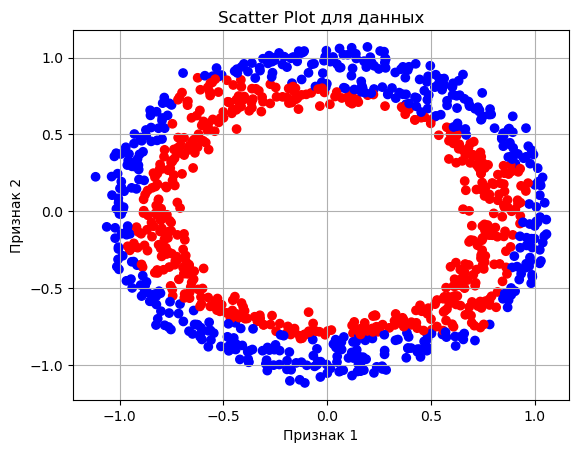

In [156]:
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=model(dataset[:][0]).argmax(dim=1), cmap='bwr')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Scatter Plot для данных')
plt.grid(True)
plt.show()

<p class="task" id="3"></p>

3\. `CrossEntropyLoss` может быть использована для задачи классификации на любое количество классов. Для задачи бинарной классификации существуют специфические функции потерь. Решите задачу 2, используя `BCEWithLogitsLoss` в качестве функции потерь.

- [X] Проверено на семинаре

In [166]:
def train_model(model, criterion, optimizer, loader, n_epochs=1000, print_every=500):
    epoch_losses = []
    for epoch in range(n_epochs + 1):
        model.train()
        accum_losses = []
        for X_batch, y_batch in loader:
            y_batch = y_batch.unsqueeze(1).float()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            accum_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = np.mean(accum_losses)
        epoch_losses.append(epoch_loss)
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}')
    return epoch_losses

In [167]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

Epoch [0/1000], Loss: 0.6869
Epoch [500/1000], Loss: 0.6839
Epoch [1000/1000], Loss: 0.6720


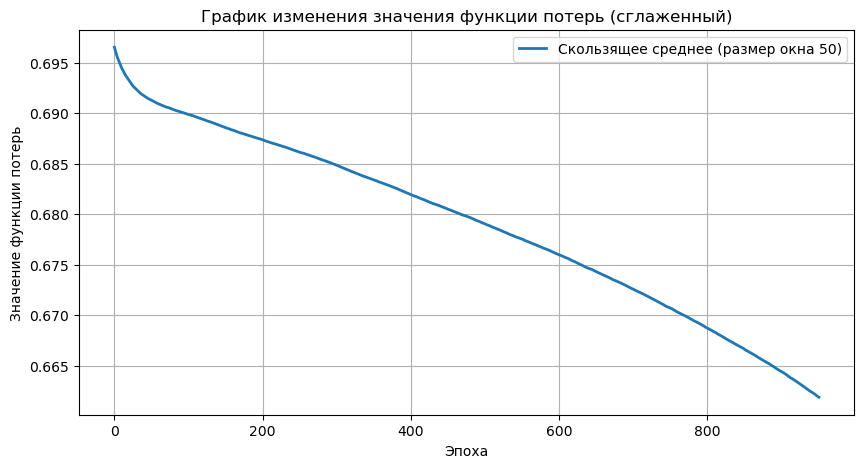

In [168]:
dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
epoch_losses = train_model(model, criterion, optimizer, train_loader)
plot_loss_curve(epoch_losses)

In [176]:
y_pred_train = (model(train_dataset[:][0]).sigmoid() > 0.5).squeeze(1).int()
y_true_train = train_dataset[:][1]
print(f"Train Accuracy: {M.Accuracy(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Recall: {M.Precision(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train F1Score: {M.Recall(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Precision: {M.F1Score(task='binary')(y_pred_train, y_true_train).item():.4f}")

Train Accuracy: 0.7350
Train Recall: 0.7383
Train F1Score: 0.7383
Train Precision: 0.7383


In [179]:
y_pred_test = (model(test_dataset[:][0]).sigmoid() > 0.5).squeeze(1).int()
y_true_test = test_dataset[:][1]
print(f"Test Accuracy: {M.Accuracy(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Recall: {M.Precision(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test F1Score: {M.Recall(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Precision: {M.F1Score(task='binary')(y_pred_test, y_true_test).item():.4f}")

Test Accuracy: 0.7300
Test Recall: 0.7303
Test F1Score: 0.6842
Test Precision: 0.7065


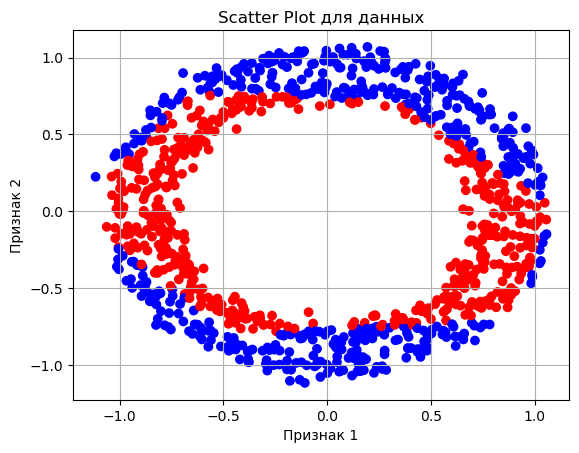

In [187]:
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=(model(dataset[:][0]).sigmoid() > 0.5), cmap='bwr')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Scatter Plot для данных')
plt.grid(True)
plt.show()

<p class="task" id="4"></p>

4\. На практике часто задача классификации является несбалансированной. В файлах каталога `imb_task` содержится несбалансированный набор данных. Обучите модель без учета несбалансированности классов (аналогично предыдущим заданиям, можно использовать любую подходящую функцию потерь). Повысьте качество модели (в смысле F1) путем модификации функции потерь (указания специального аргумента, позволяющего учесть несбалансированность классов).

- [X] Проверено на семинаре

In [226]:
X = th.load('.\\imb_task\\imb_task\\imb_X.th').float()
y = th.load('.\\imb_task\\imb_task\\imb_y.th').long()
X.shape, y.shape

(torch.Size([1650, 2]), torch.Size([1650]))

In [227]:
def train_model(model, criterion, optimizer, loader, n_epochs=1000, print_every=500):
    epoch_losses = []
    for epoch in range(n_epochs + 1):
        model.train()
        accum_losses = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            accum_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = np.mean(accum_losses)
        epoch_losses.append(epoch_loss)
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}')
    return epoch_losses

In [228]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=2),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [229]:
dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
epoch_losses = train_model(model, criterion, optimizer, train_loader)

Epoch [0/1000], Loss: 0.5269
Epoch [500/1000], Loss: 0.2515
Epoch [1000/1000], Loss: 0.1831


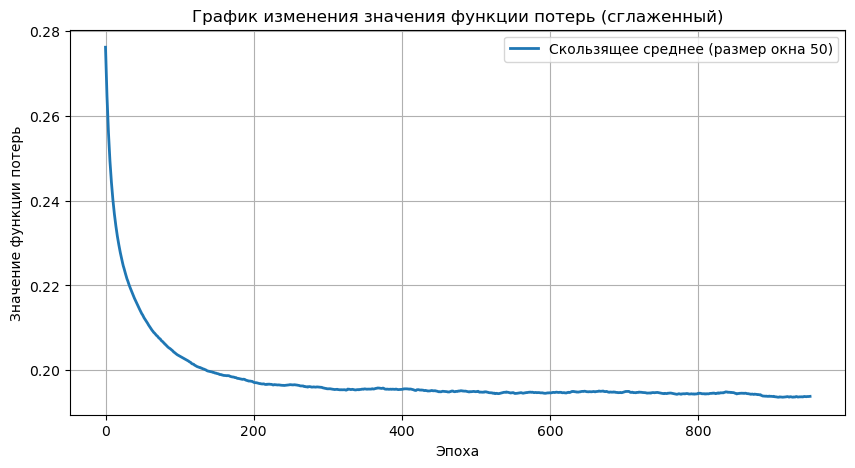

In [230]:
plot_loss_curve(epoch_losses)

In [231]:
y_pred_train = model(train_dataset[:][0]).argmax(dim=1)
y_true_train = train_dataset[:][1]
print(f"Train Accuracy: {M.Accuracy(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Recall: {M.Precision(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train F1Score: {M.Recall(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Precision: {M.F1Score(task='binary')(y_pred_train, y_true_train).item():.4f}")

Train Accuracy: 0.9235
Train Recall: 0.5800
Train F1Score: 0.2661
Train Precision: 0.3648


In [233]:
y_pred_test = model(test_dataset[:][0]).argmax(dim=1)
y_true_test = test_dataset[:][1]
print(f"Test Accuracy: {M.Accuracy(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Recall: {M.Precision(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test F1Score: {M.Recall(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Precision: {M.F1Score(task='binary')(y_pred_test, y_true_test).item():.4f}")

Test Accuracy: 0.8848
Test Recall: 0.5789
Test F1Score: 0.2683
Test Precision: 0.3667


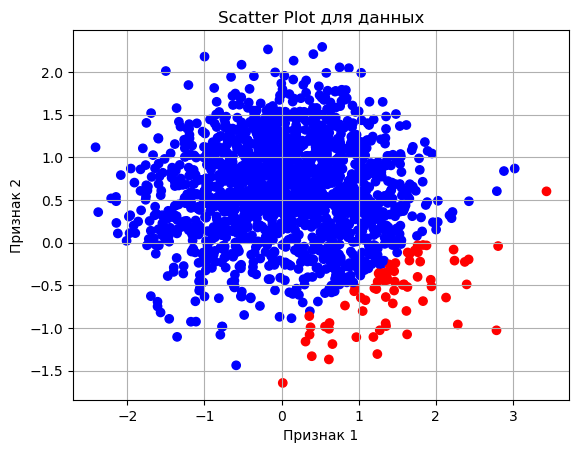

In [234]:
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=model(dataset[:][0]).argmax(dim=1), cmap='bwr')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Scatter Plot для данных')
plt.grid(True)
plt.show()

In [256]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=2),
)

class_counts = th.bincount(y)
class_weights = 1.0 / class_counts.float()
weights = class_weights / class_weights.sum() 
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [236]:
dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
epoch_losses = train_model(model, criterion, optimizer, train_loader)

Epoch [0/1000], Loss: 0.6537
Epoch [500/1000], Loss: 0.2756
Epoch [1000/1000], Loss: 0.3620


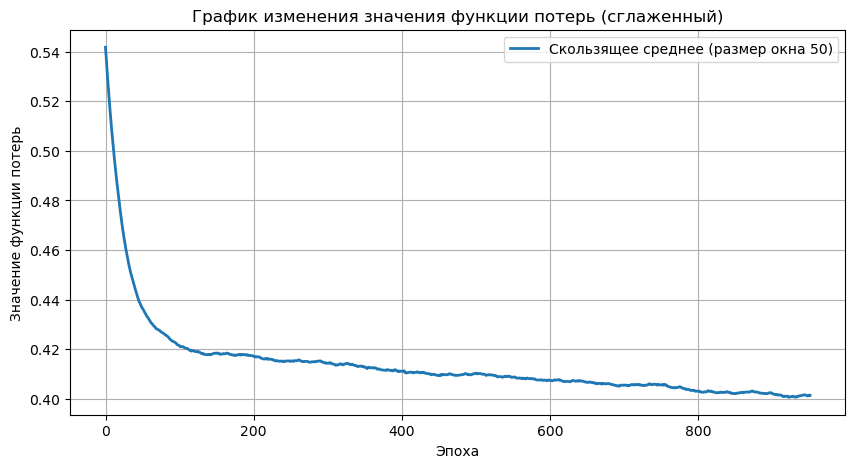

In [237]:
plot_loss_curve(epoch_losses)

In [238]:
y_pred_train = model(train_dataset[:][0]).argmax(dim=1)
y_true_train = train_dataset[:][1]
print(f"Train Accuracy: {M.Accuracy(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Recall: {M.Precision(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train F1Score: {M.Recall(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Precision: {M.F1Score(task='binary')(y_pred_train, y_true_train).item():.4f}")

Train Accuracy: 0.8167
Train Recall: 0.3127
Train F1Score: 0.8347
Train Precision: 0.4550


In [239]:
y_pred_test = model(test_dataset[:][0]).argmax(dim=1)
y_true_test = test_dataset[:][1]
print(f"Test Accuracy: {M.Accuracy(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Recall: {M.Precision(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test F1Score: {M.Recall(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Precision: {M.F1Score(task='binary')(y_pred_test, y_true_test).item():.4f}")

Test Accuracy: 0.7818
Test Recall: 0.2688
Test F1Score: 0.8621
Test Precision: 0.4098


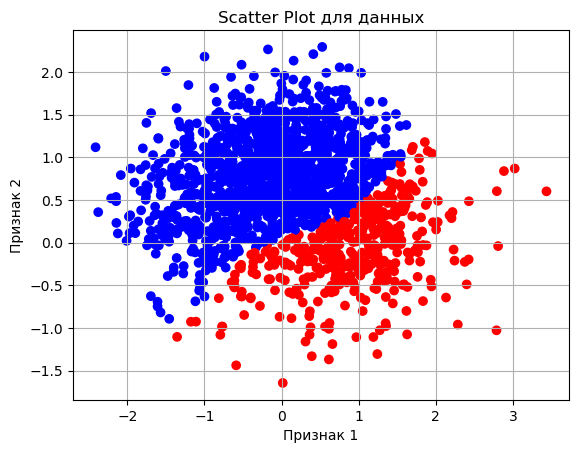

In [240]:
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=model(dataset[:][0]).argmax(dim=1), cmap='bwr')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Scatter Plot для данных')
plt.grid(True)
plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, повысив качество модели за счет использования `WeightedRandomSampler` вместо модификации функции потерь.

- [X] Проверено на семинаре

In [246]:
from torch.utils.data import WeightedRandomSampler

In [247]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=2),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [251]:
train_labels = train_dataset[:][1]
class_counts = th.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
train_sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
epoch_losses = train_model(model, criterion, optimizer, train_loader)

Epoch [0/1000], Loss: 0.3178
Epoch [500/1000], Loss: 0.2692
Epoch [1000/1000], Loss: 0.0888


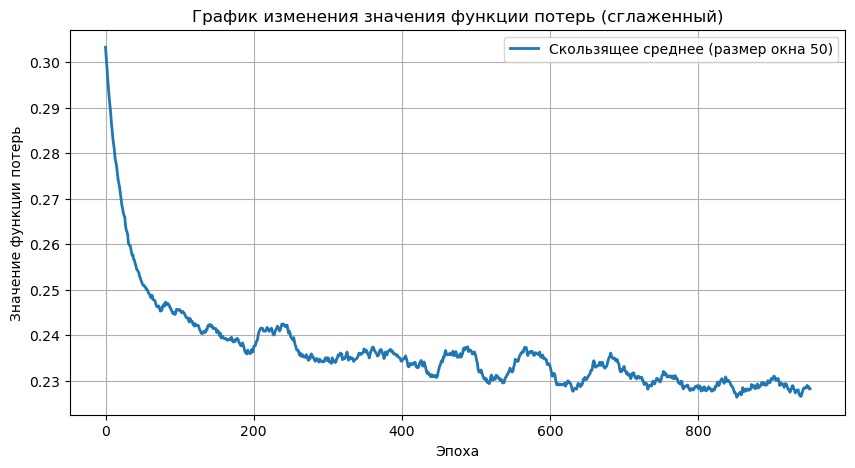

In [252]:
plot_loss_curve(epoch_losses)

In [253]:
y_pred_train = model(train_dataset[:][0]).argmax(dim=1)
y_true_train = train_dataset[:][1]
print(f"Train Accuracy: {M.Accuracy(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Recall: {M.Precision(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train F1Score: {M.Recall(task='binary')(y_pred_train, y_true_train).item():.4f}")
print(f"Train Precision: {M.F1Score(task='binary')(y_pred_train, y_true_train).item():.4f}")

Train Accuracy: 0.9212
Train Recall: 0.7429
Train F1Score: 0.2149
Train Precision: 0.3333


In [254]:
y_pred_test = model(test_dataset[:][0]).argmax(dim=1)
y_true_test = test_dataset[:][1]
print(f"Test Accuracy: {M.Accuracy(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Recall: {M.Precision(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test F1Score: {M.Recall(task='binary')(y_pred_test, y_true_test).item():.4f}")
print(f"Test Precision: {M.F1Score(task='binary')(y_pred_test, y_true_test).item():.4f}")

Test Accuracy: 0.9212
Test Recall: 0.6667
Test F1Score: 0.2069
Test Precision: 0.3158


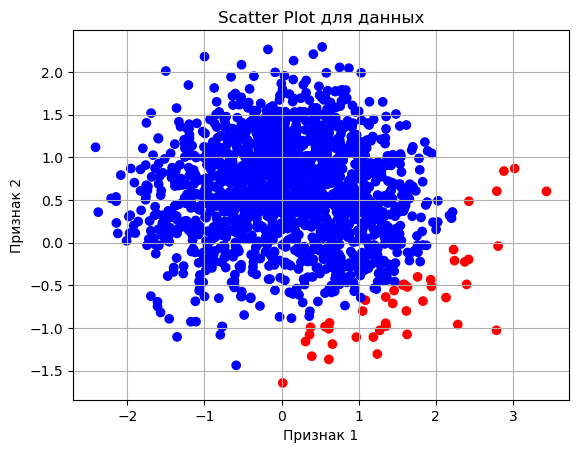

In [255]:
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=model(dataset[:][0]).argmax(dim=1), cmap='bwr')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Scatter Plot для данных')
plt.grid(True)
plt.show()